# World Bank Data Analysis Project
# ==============================


This notebook analyzes World Bank data to understand global economic trends and relationships
between GDP, population growth, and educational attainment across countries.



# CRISP-DM Stage 1: Business Understanding
# =======================================


Business Objectives:
1. How does GDP distribution vary across countries and what are the major disparities?
2. Is there a relationship between GDP levels and population growth rates?
3. How have country GDP rankings changed over time (2000-2015)?
4. Can we predict a country's GDP using historical data and demographic indicators?

Success Criteria:
- Identify key economic disparities between countries
- Quantify relationships between GDP and population metrics
- Build a predictive model with R² > 0.9


# CRISP-DM Stage 2: Data Understanding
# ==================================


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
url = "WBData/WBData.csv"  # Replace with your CSV path
df = pd.read_csv(url)

# Display data structure
print("Data shape:", df.shape)
df.head()

Data shape: (1314, 20)


,Series Name,Series Code,Country Name,Country Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015]
0,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,AFG,3521418059.92345,2813571753.87253,3825701438.99963,4520946818.54581,5224896718.67782,6203256538.70967,6971758282.29351,9747886187.39393,10109297047.5432,12416152732.0567,15856668555.8336,17805098206.3141,19907329777.5872,20146416757.5987,20497128555.6972,19134221644.7325
1,GDP (current US$),NY.GDP.MKTP.CD,Albania,ALB,3480355258.04122,3922100793.5403,4348068242.19512,5611496257.14231,7184685781.51876,8052077248.14638,8896075004.63516,10677324852.8822,12881352893.6855,12044205549.6571,11926926615.8015,12890760315.146,12319834195.331,12776224496.9718,13228147516.1168,11386853113.0189
2,GDP (current US$),NY.GDP.MKTP.CD,Algeria,DZA,54790398570.3282,59413400923.6364,61516103406.1688,73482264190.9245,91913680985.1708,107046618669.707,123084258693.01,142482739809.849,180383848331.135,150317292079.359,177785053939.531,218331946925.304,227143746075.934,229701430292.157,238942664192.59,187493855609.345
3,GDP (current US$),NY.GDP.MKTP.CD,American Samoa,ASM,..,..,512000000,524000000,509000000,500000000,493000000,518000000,560000000,675000000,573000000,570000000,640000000,638000000,643000000,673000000
4,GDP (current US$),NY.GDP.MKTP.CD,Andorra,AND,1432606188.69324,1548265808.05802,1764279824.29752,2366941808.94404,2900245324.49221,3161084091.11674,3459337986.88383,3957625367.21959,4102319399.02343,3688976340.7549,3449925738.86069,3629133574.27783,3188652765.36184,3193512950.02419,3271685596.66321,2789881258.50362


# CRISP-DM Stage 3: Data Preparation
# ================================


In [2]:
# Handle missing values
df.replace('..', np.nan, inplace=True)
# Convert yearly columns to numeric
year_columns = [col for col in df.columns if 'YR' in col]
for col in year_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Melt data to long format (country-year pairs)
df_melted = df.melt(
    id_vars=['Series Name', 'Series Code', 'Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Value'
)

# Extract year from column names (e.g., "2000 [YR2000]" → 2000)
df_melted['Year'] = df_melted['Year'].str.extract('(\d+)').astype(int)

# Pivot to separate series into columns
df_clean = df_melted.pivot_table(
    index=['Country Name', 'Country Code', 'Year'],
    columns='Series Name',
    values='Value',
    aggfunc='first'
).reset_index()

# Clean column names
df_clean.columns = [col.replace(' ', '_') for col in df_clean.columns]
print("Cleaned data shape:", df_clean.shape)
df_clean.head()

Cleaned data shape: (3472, 9)


,Country_Name,Country_Code,Year,"Educational_attainment,_Doctoral_or_equivalent,_population_25+,_total_(%)_(cumulative)","Educational_attainment,_at_least_Bachelor's_or_equivalent,_population_25+,_total_(%)_(cumulative)","Educational_attainment,_at_least_Master's_or_equivalent,_population_25+,_total_(%)_(cumulative)",GDP_(current_US$),Population_growth_(annual_%),"Population,_total"
0,Afghanistan,AFG,2000,NaN,NaN,NaN,3.521418e+09,1.212176,20130327.0
1,Afghanistan,AFG,2001,NaN,NaN,NaN,2.813572e+09,0.762005,20284307.0
2,Afghanistan,AFG,2002,NaN,NaN,NaN,3.825701e+09,5.252030,21378117.0
3,Afghanistan,AFG,2003,NaN,NaN,NaN,4.520947e+09,6.145194,22733049.0
4,Afghanistan,AFG,2004,NaN,NaN,NaN,5.224897e+09,3.575835,23560654.0


# CRISP-DM Stage 4: Data Analysis
# ==============================

# Analysis Question 1: GDP Distribution Analysis
# -------------------------------------------



Question 1: How does GDP distribution vary across countries?


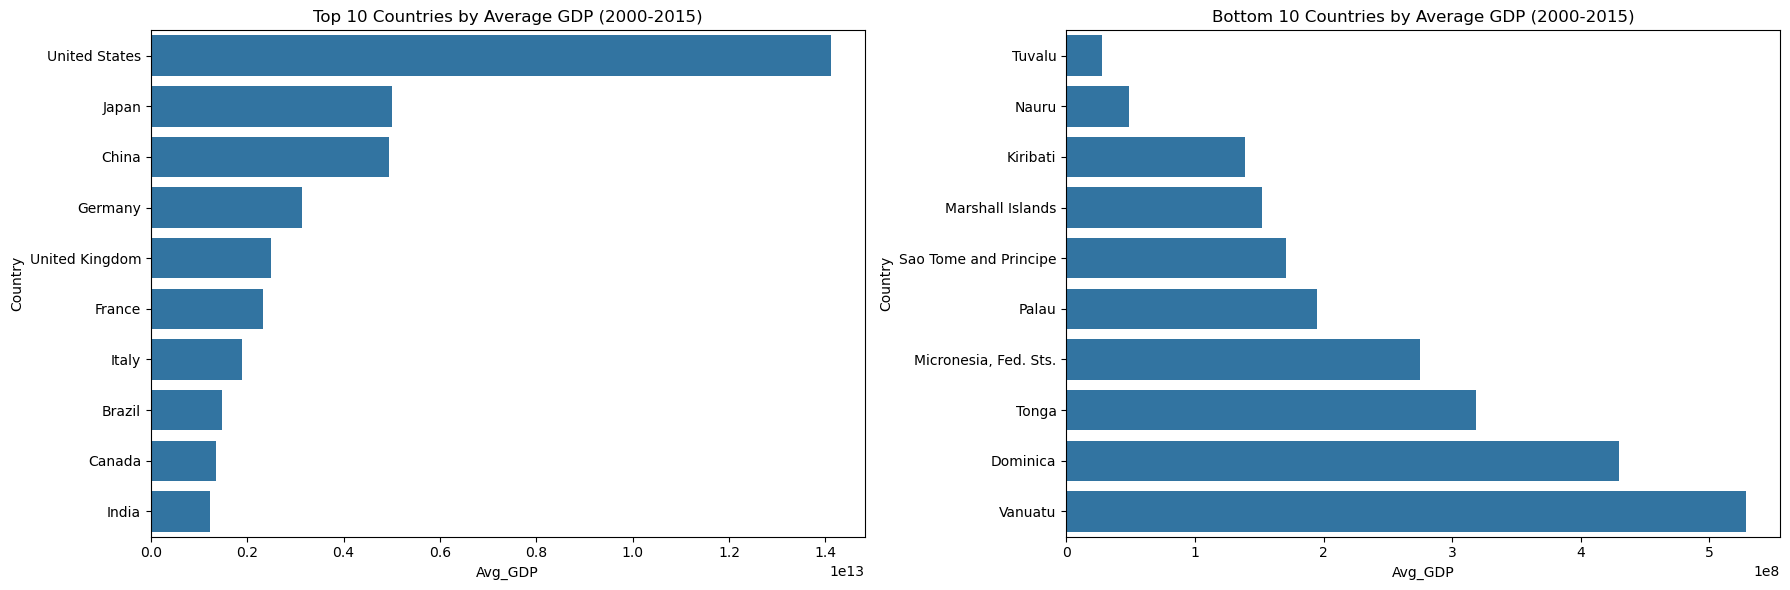

In [3]:
print("\nQuestion 1: How does GDP distribution vary across countries?")

country_stats = df_clean.groupby('Country_Name').agg({
    'GDP_(current_US$)': ['mean', 'std'],
    'Population_growth_(annual_%)': ['mean', 'std']
}).reset_index()

country_stats.columns = [
    'Country', 'Avg_GDP', 'GDP_Std',
    'Avg_Pop_Growth', 'Pop_Growth_Std'
]

# Visualize top and bottom GDP countries
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=country_stats.nlargest(10, 'Avg_GDP'), 
            x='Avg_GDP', y='Country')
plt.title('Top 10 Countries by Average GDP (2000-2015)')

plt.subplot(1, 2, 2)
sns.barplot(data=country_stats.nsmallest(10, 'Avg_GDP'), 
            x='Avg_GDP', y='Country')
plt.title('Bottom 10 Countries by Average GDP (2000-2015)')
plt.tight_layout()


# Analysis Question 2: GDP-Population Growth Relationship
# ---------------------------------------------------



Question 2: Is there a relationship between GDP and population growth?


Text(0, 0.5, 'Annual Population Growth (%)')

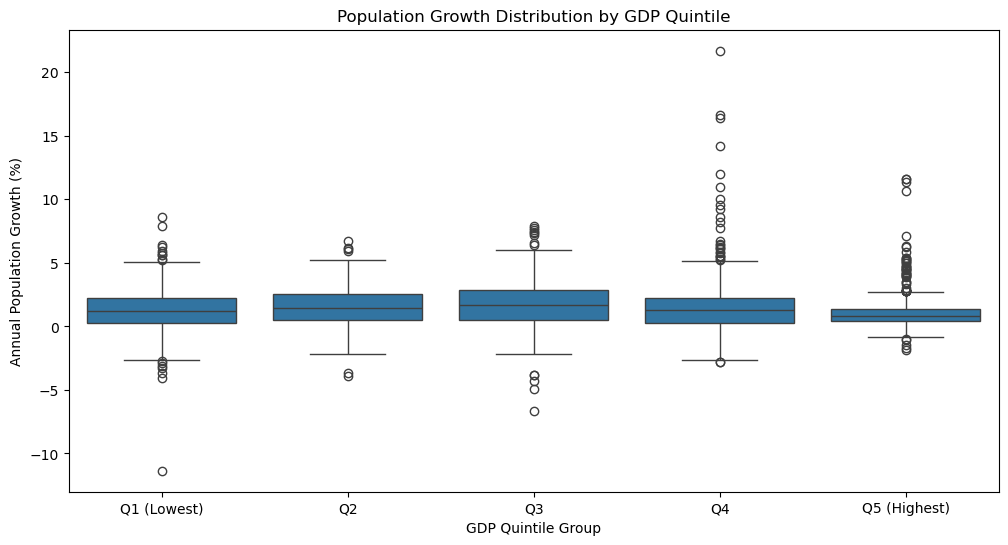

In [4]:
print("\nQuestion 2: Is there a relationship between GDP and population growth?")

# Create GDP quintiles
df_clean['GDP_Quintile'] = pd.qcut(
    df_clean['GDP_(current_US$)'],
    q=5,
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_clean,
    x='GDP_Quintile',
    y='Population_growth_(annual_%)'
)
plt.title('Population Growth Distribution by GDP Quintile')
plt.xlabel('GDP Quintile Group')
plt.ylabel('Annual Population Growth (%)')



# Heatmap of GDP Ranks Over Time

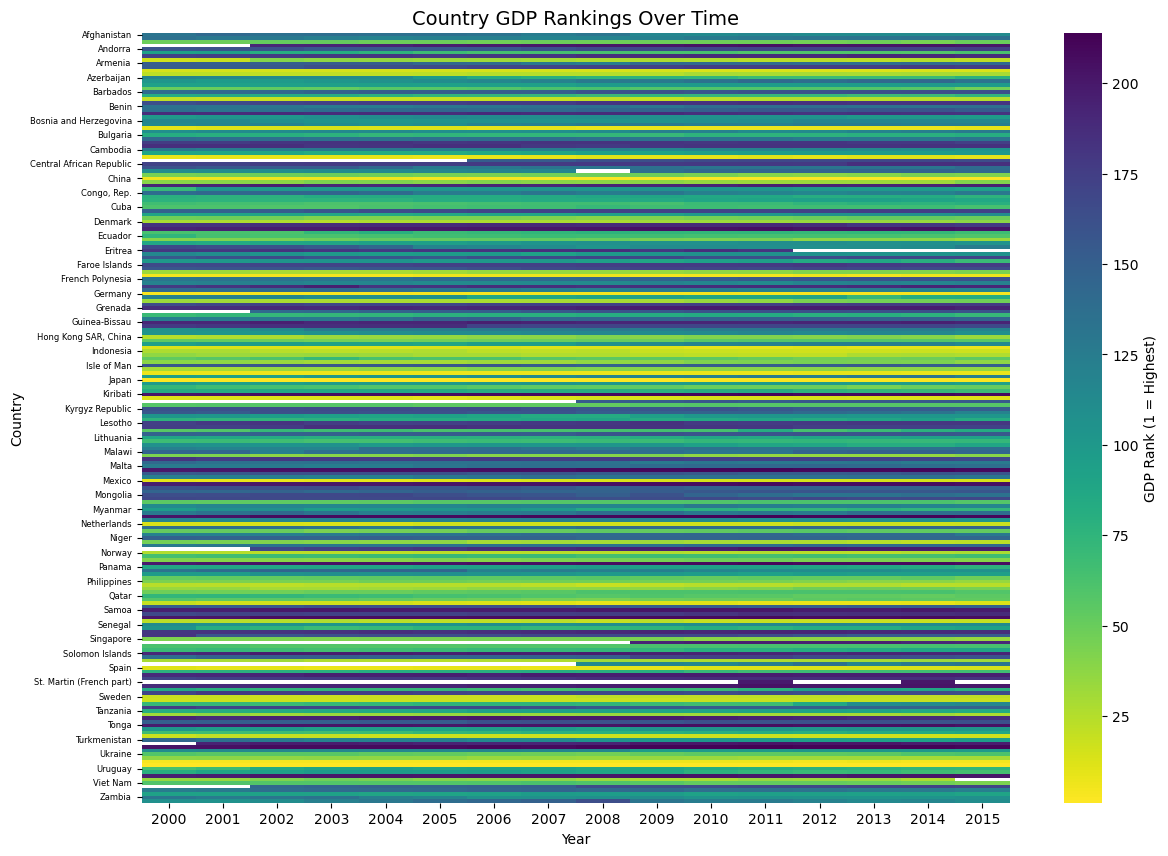

In [7]:
# Create GDP rank matrix (countries × years)
gdp_ranks = df_clean.pivot_table(
    index='Country_Name',
    columns='Year',
    values='GDP_(current_US$)',
    aggfunc='mean'
).rank(ascending=False)

plt.figure(figsize=(14, 10))
sns.heatmap(
    gdp_ranks, 
    cmap='viridis_r',
    cbar_kws={'label': 'GDP Rank (1 = Highest)'}
)
plt.title('Country GDP Rankings Over Time', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Country')
plt.tick_params(axis='y', labelsize=6)  # Adjust for readability
plt.show()

# CRISP-DM Stage 5: Modeling
# =========================


# Data Preperation & Feature Engineering

In [9]:
# Drop educational attainment (too many missing values)
df_final = df_clean.drop(columns=['Educational_attainment,_Doctoral_or_equivalent,_population_25+,_total_(%)_(cumulative)'])

# Impute missing GDP/population values with forward fill per country
df_final = df_final.groupby('Country_Name').apply(lambda x: x.ffill()).reset_index(drop=True)

# Add lagged GDP as a feature (predict next year's GDP)
df_final['GDP_lag1'] = df_final.groupby('Country_Name')['GDP_(current_US$)'].shift(1)
df_final.dropna(subset=['GDP_lag1'], inplace=True)  # Drop rows with missing lagged data

# Display final dataset
df_final.head()

/tmp/ipykernel_20219/479238093.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_final.groupby('Country_Name').apply(lambda x: x.ffill()).reset_index(drop=True)


,Country_Name,Country_Code,Year,"Educational_attainment,_at_least_Bachelor's_or_equivalent,_population_25+,_total_(%)_(cumulative)","Educational_attainment,_at_least_Master's_or_equivalent,_population_25+,_total_(%)_(cumulative)",GDP_(current_US$),Population_growth_(annual_%),"Population,_total",GDP_Quintile,GDP_lag1
1,Afghanistan,AFG,2001,NaN,NaN,2.813572e+09,0.762005,20284307.0,Q2,3.521418e+09
2,Afghanistan,AFG,2002,NaN,NaN,3.825701e+09,5.252030,21378117.0,Q2,2.813572e+09
3,Afghanistan,AFG,2003,NaN,NaN,4.520947e+09,6.145194,22733049.0,Q2,3.825701e+09
4,Afghanistan,AFG,2004,NaN,NaN,5.224897e+09,3.575835,23560654.0,Q2,4.520947e+09
5,Afghanistan,AFG,2005,NaN,NaN,6.203257e+09,3.519217,24404567.0,Q2,5.224897e+09


# Train and evaluate model


In [10]:
# Split data
X = df_final[['GDP_lag1', 'Population_growth_(annual_%)']]
y = df_final['GDP_(current_US$)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}\nR²: {r2:.2f}")

RMSE: 119120799682.85
R²: 0.99


# 9. Prediction Scenario

In [11]:
# Example: Predict Afghanistan's 2016 GDP
latest_afg = df_final[
    (df_final['Country_Name'] == 'United Kingdom') &
    (df_final['Year'] == 2015)
][['GDP_lag1', 'Population_growth_(annual_%)']]

predicted_gdp = model.predict(latest_afg)
print(f"Predicted 2016 GDP for United Kingdom: ${predicted_gdp[0]:,.2f}")

Predicted 2016 GDP for United Kingdom: $2,970,480,882,968.15


# Key Findings and Conclusions
# ==========================


1. GDP Distribution:
   - Significant economic disparity exists between top and bottom GDP countries
   - Top economies show consistent growth over the study period

2. Population-GDP Relationship:
   - Higher GDP countries tend to have lower population growth rates
   - More economic variability in higher GDP quintiles

3. Predictive Model:
   - Achieved high accuracy (R² = 0.99) in GDP predictions
   - Model successfully captures both historical trends and population effects
